In [6]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os
import igraph

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
from helpers import infodynamics

cf = yaml.safe_load(Path('config.yml').read_text())

In [2]:
data = dataloader.load()
dists, labels, words, sem_col_translator = data['dists'],data['labels'],data['words'],data['translator']

In [3]:
# Create a dictionary of day:theta pairs
dict_date_theta = {d:_.to_numpy() for d,_ in dists.groupby(dists.index.to_period('M'))}
stats, mi_arrays = diachronic_linkage(dict_date_theta)
dict_str_period = {p.strftime('%Y-%m'):p for p in mi_arrays.keys()}
# ps = [str(x) + '-09' for x in range(1948,1963,2)]

100%|██████████| 218/218 [00:15<00:00, 14.25it/s]


In [10]:
def plot_network(month,ax,zscore_threshold):
    """
    month (str): 1945-01
    """

    mi_array_target_date = mi_arrays[dict_str_period[month]]
    mi_array_target_date[mi_array_target_date < 0] = 0 # set all negative linkages to zero

    # Flatten Mutual Information array, apply zscores, filter, add labels (N.B., some labels occur more than once)
    fmx = flatten_mi_array(mi_array_target_date)
    fmx[2] = fmx[[2]].apply(zscore)
    fmx = fmx[fmx[2] > zscore_threshold]
    fmx[0] = [labels[sem_col_translator[x]] for x in fmx[0]]
    fmx[1] = [labels[sem_col_translator[x]] for x in fmx[1]]
    fmx.columns = ['source','target','weight']
    fmx = fmx[fmx.source != fmx.target]

    # Prepare Network Format
    fmx['weight'] = fmx.weight * 500
    tuples = [tuple(x) for x in fmx.values]
    G = igraph.Graph.TupleList(tuples, directed = True, edge_attrs = ['weight'])
    weights= G.es['weight']
    G = G.as_undirected()
    mlc = G.community_multilevel()
    visual_style = dict()
    visual_style["bbox"] = (500, 500)
    visual_style["vertex_label"] = G.vs["name"]
    igraph.plot(mlc,mark_groups = True,target=ax,**visual_style)
    ax.set_title(month)
    return G,weights

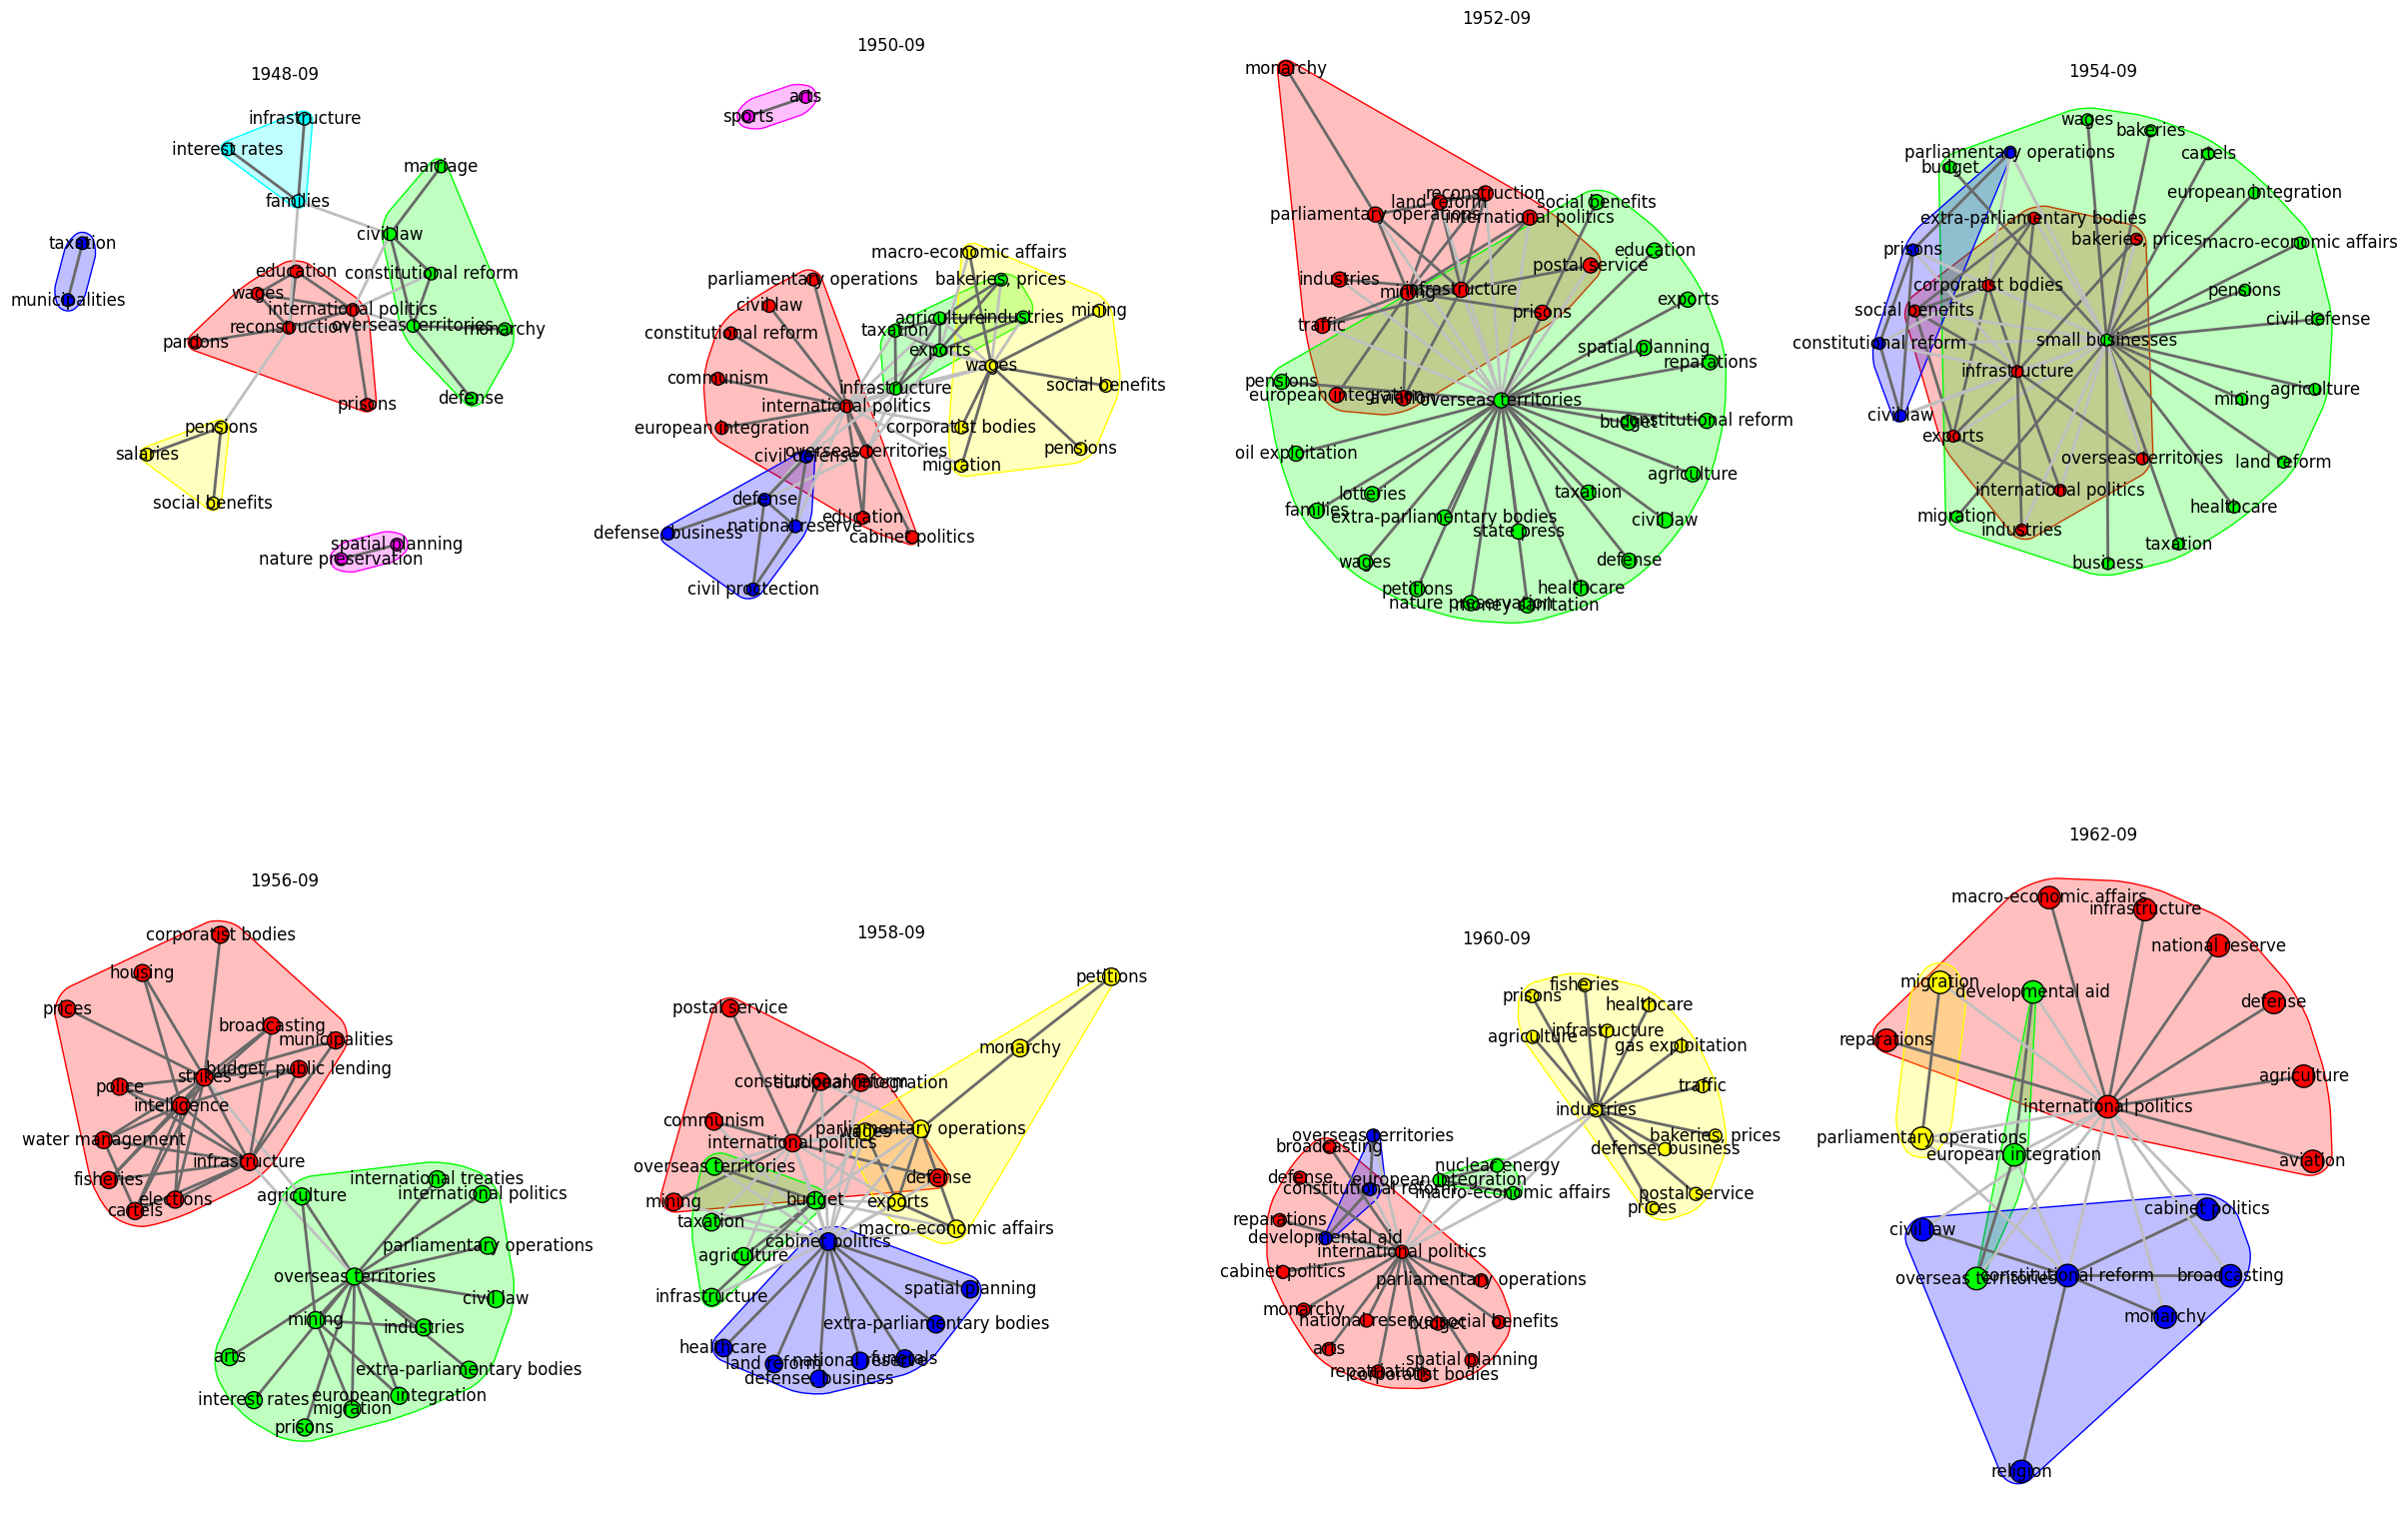

In [13]:
fig,axs = plt.subplots(2,4,figsize=(30,20))
ps = [str(x) + '-09' for x in range(1948,1963,2)]
c = 0
for c,ax in enumerate(axs.flatten()):
    plot_network(ps[c],ax,6)
    c += 1

plt.savefig('figs/example-network-zscorethres-6.pdf')